# script to get V1 from freesurfer

In [1]:
import nibabel as nb
import numpy as np
import hcp_utils
from scipy.stats import zscore
import pandas as pd

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
with open('pilots_ru_dm_list.txt', 'r') as file:
    sub_list = file.readlines()
good_subjects_list = [line.strip() for line in sub_list]
good_subjects_list.remove('NDARUT018UYN')

#NDARUT018UYN DNE
#error: MRISread(/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/freesurfer_7.3.2/sub-NDARUT018UYN/surf/lh.white): could not open file

In [ ]:
v1_list=[]
for sub in good_subjects_list:
    #sub='NDARHJ830RXD'
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    
    label_gii = nb.load(f'/om2/scratch/tmp/jsmentch/nat_asd/outputs/v1_roi/sub-{sub}_V1.dlabel.nii')
    label_data = label_gii.get_fdata()
    _,ind=np.where(label_data==2)
    
    
    img_cortex=[]
    for i in np.arange(img_y.shape[0]):
        img_cortex.append(hcp_utils.cortex_data(img_y[i,:])[ind])
    np.asanyarray(img_cortex)
    v1_list.append(np.asanyarray(img_cortex))
    np.save(f'../data/features/{sub}_DM_v1.npy', np.asanyarray(img_cortex) )
    

#### load saved v1

In [3]:
v1_list=[]
for sub in good_subjects_list:

    img_cortex=np.load(f'../data/features/{sub}_DM_v1.npy')
    v1_list.append(img_cortex)
    
    

In [4]:
# # Basic statistics
# grand_mean = np.mean(timecourse)
# variance = np.var(timecourse)
# std_dev = np.std(timecourse)

# # Measures of fluctuation
# range_ = np.ptp(timecourse)
# iqr = np.percentile(timecourse, 75) - np.percentile(timecourse, 25)
# mad = np.mean(np.abs(timecourse - mean))
# cv = std_dev / mean

# # Temporal dynamics
# autocorrelation = np.correlate(timecourse, timecourse, mode='full') / np.var(timecourse) / len(timecourse)
# autocorrelation = autocorrelation[autocorrelation.size // 2:]
"""
Basic Statistics
Mean: The average value of the timecourse.
Variance: A measure of the spread of the timecourse values around the mean.
Standard Deviation: The square root of the variance, indicating how much the values typically deviate from the mean.
Measures of Fluctuation
Range: The difference between the maximum and minimum values.
Interquartile Range (IQR): The difference between the 75th and 25th percentiles, showing the range within which the middle 50% of the data lie.
Mean Absolute Deviation (MAD): The average of the absolute deviations from the mean.
Coefficient of Variation (CV): The ratio of the standard deviation to the mean, indicating the relative variability.
"""


import nat_asd_utils

import numpy as np
from scipy.signal import correlate, welch, find_peaks
from scipy.stats import skew, kurtosis, variation


# Define a function to calculate RMS
def compute_rms(timecourse):
    return np.sqrt(np.mean(np.square(timecourse)))

# Compute skewness and kurtosis
def compute_skewness(timecourse):
    return skew(timecourse)

def compute_kurtosis(timecourse):
    return kurtosis(timecourse)


metrics_z = {
    'grand_mean': [],
    'mean_variance': [],
    'mean_std_dev': [],
    'mean_range': [],
    'mean_iqr': [],
    'mean_mad': [],
    'mean_cv': [],
    'grand_autocorrelation': [],
    'grand_psd': [],
    'grand_rms': [],
    'grand_peak_count': [],
    'grand_peak_amplitude': [],
    'grand_peak_frequency': [],
    'grand_skewness': [],
    'grand_kurtosis': [],
}


v1_list_z=nat_asd_utils.apply_zscore(v1_list)

for v in v1_list_z:
    v_mean=np.mean(v,axis=1)
    metrics_z['grand_mean'].append(np.mean(v_mean))
    metrics_z['mean_variance'].append(np.var(v_mean))
    metrics_z['mean_std_dev'].append(np.std(v_mean))
    metrics_z['mean_range'].append(np.ptp(v_mean))
    metrics_z['mean_iqr'].append(np.percentile(v_mean, 75) - np.percentile(v_mean, 25))
    metrics_z['mean_mad'].append(np.mean(np.abs(v_mean - np.mean(v_mean))))
    metrics_z['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))

    # Compute Autocorrelation
    v_autocorr = correlate(v_mean, v_mean, mode='full')
    v_autocorr = v_autocorr[v_autocorr.size // 2:]  # Keep positive lags
    metrics_z['grand_autocorrelation'].append(np.mean(v_autocorr))

    # Compute Power Spectral Density (PSD)
    freqs, psd = welch(v_mean)
    metrics_z['grand_psd'].append(np.mean(psd))  # Mean PSD

    # Compute Root Mean Square (RMS)
    metrics_z['grand_rms'].append(compute_rms(v_mean))

    # Peak Detection
    peaks, _ = find_peaks(v_mean)
    peak_count = float(len(peaks))
    metrics_z['grand_peak_count'].append(float(peak_count))
    
    # Amplitude of Peaks
    peak_amplitudes = v_mean[peaks] if peak_count > 0 else np.array([])
    if peak_count > 0:
        mean_peak_amplitude = np.mean(peak_amplitudes)
    else:
        mean_peak_amplitude = 0
    metrics_z['grand_peak_amplitude'].append(mean_peak_amplitude)

    # Peak Frequency
    if peak_count > 0:
        peak_frequency = peak_count / len(v_mean)  # Peaks per sample
    else:
        peak_frequency = 0
    metrics_z['grand_peak_frequency'].append(peak_frequency)

    metrics_z['grand_skewness'].append(compute_skewness(v_mean))
    metrics_z['grand_kurtosis'].append(compute_kurtosis(v_mean))

/tmp/ipykernel_2453818/706784370.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  metrics_z['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))


In [5]:
#repeat but for z-scored
import nat_asd_utils

# Define a function to calculate RMS
def compute_rms(timecourse):
    return np.sqrt(np.mean(np.square(timecourse)))

# Compute skewness and kurtosis
def compute_skewness(timecourse):
    return skew(timecourse)

def compute_kurtosis(timecourse):
    return kurtosis(timecourse)

metrics = {
    'StackedR2': [],
    'grand_mean': [],
    'mean_variance': [],
    'mean_std_dev': [],
    'mean_range': [],
    'mean_iqr': [],
    'mean_mad': [],
    'mean_cv': [],
    'grand_autocorrelation': [],
    'grand_psd': [],
    'grand_rms': [],
    'grand_peak_count': [],
    'grand_peak_amplitude': [],
    'grand_peak_frequency': [],
    'grand_skewness': [],
    'grand_kurtosis': []
}

for v in v1_list:
    v_mean=np.mean(v,axis=1)
    metrics['grand_mean'].append(np.mean(v_mean))
    metrics['mean_variance'].append(np.var(v_mean))
    metrics['mean_std_dev'].append(np.std(v_mean))
    metrics['mean_range'].append(np.ptp(v_mean))
    metrics['mean_iqr'].append(np.percentile(v_mean, 75) - np.percentile(v_mean, 25))
    metrics['mean_mad'].append(np.mean(np.abs(v_mean - np.mean(v_mean))))
    metrics['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))

    # Compute Autocorrelation
    v_autocorr = correlate(v_mean, v_mean, mode='full')
    v_autocorr = v_autocorr[v_autocorr.size // 2:]  # Keep positive lags
    metrics['grand_autocorrelation'].append(np.mean(v_autocorr))

    # Compute Power Spectral Density (PSD)
    freqs, psd = welch(v_mean)
    metrics['grand_psd'].append(np.mean(psd))  # Mean PSD

    # Compute Root Mean Square (RMS)
    metrics['grand_rms'].append(compute_rms(v_mean))

    # Peak Detection
    peaks, _ = find_peaks(v_mean)
    peak_count = float(len(peaks))
    metrics['grand_peak_count'].append(float(peak_count))
    
    # Amplitude of Peaks
    peak_amplitudes = v_mean[peaks] if peak_count > 0 else np.array([])
    if peak_count > 0:
        mean_peak_amplitude = np.mean(peak_amplitudes)
    else:
        mean_peak_amplitude = 0
    metrics['grand_peak_amplitude'].append(mean_peak_amplitude)

    # Peak Frequency
    if peak_count > 0:
        peak_frequency = peak_count / len(v_mean)  # Peaks per sample
    else:
        peak_frequency = 0
    metrics['grand_peak_frequency'].append(peak_frequency)

    metrics['grand_skewness'].append(compute_skewness(v_mean))
    metrics['grand_kurtosis'].append(compute_kurtosis(v_mean))

In [6]:
stackedr2_list=[]
mean_stackedr2_list=[]

for sub in good_subjects_list:
#sub=sub_list[0]
    #loaded=np.load(f'../pilot_results/feat-audio_sub-{sub}_ROI-all_PCA-1_delay-6.npz')
    loaded=np.load(f'../good_pilots/sub-{sub}_roi-a4a5_feat-cochresnet50srp05hrfssfirst_delay-0.npz')

    stackedr2_list.append(loaded['stacked_r2s'])
    mean_stackedr2_list.append(loaded['stacked_r2s'].mean())
#sub-NDAREM731BYM_roi-a4a5_feat-cochresnet50srp05hrfssfirst_delay-0.npz

In [7]:
metrics['StackedR2']=mean_stackedr2_list

In [8]:
censored_count=[]
true_censored_count=[]

for i, sub in enumerate(good_subjects_list):
    confounds_file=f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/fmriprep_23.2.0/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_desc-confounds_timeseries.tsv'
    df = pd.read_csv(confounds_file, sep='\t')
    fd=df['framewise_displacement']
    count = sum(1 for value in fd if value > 0.9)
    #print(count)
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_seg-Glasser_den-91k_stat-mean_timeseries.ptseries.nii'
    #im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    censored_count.append(count)
    true_censored_count.append(750-img_y.shape[0])


metrics['censored_count']=censored_count
metrics['true_censored_count']=true_censored_count

/tmp/ipykernel_2453818/524130736.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.asanyarray(metrics_z[m])/max(metrics_z[m]),label=f'{m}_z')


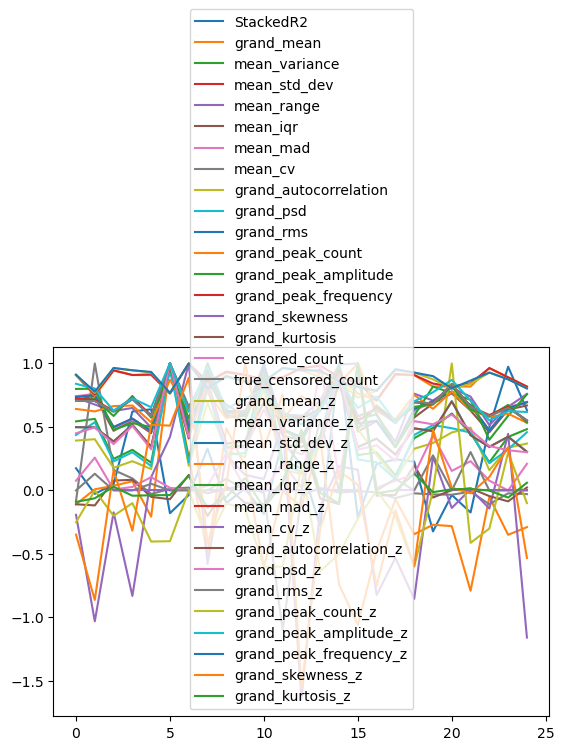

In [9]:
import matplotlib.pyplot as plt
for m in metrics:
    #print(m)
    plt.plot(np.asanyarray(metrics[m])/max(metrics[m]),label=m)
    #print(max(metrics[m]))
    plt.legend()
for m in metrics_z:
    plt.plot(np.asanyarray(metrics_z[m])/max(metrics_z[m]),label=f'{m}_z')
    plt.legend()


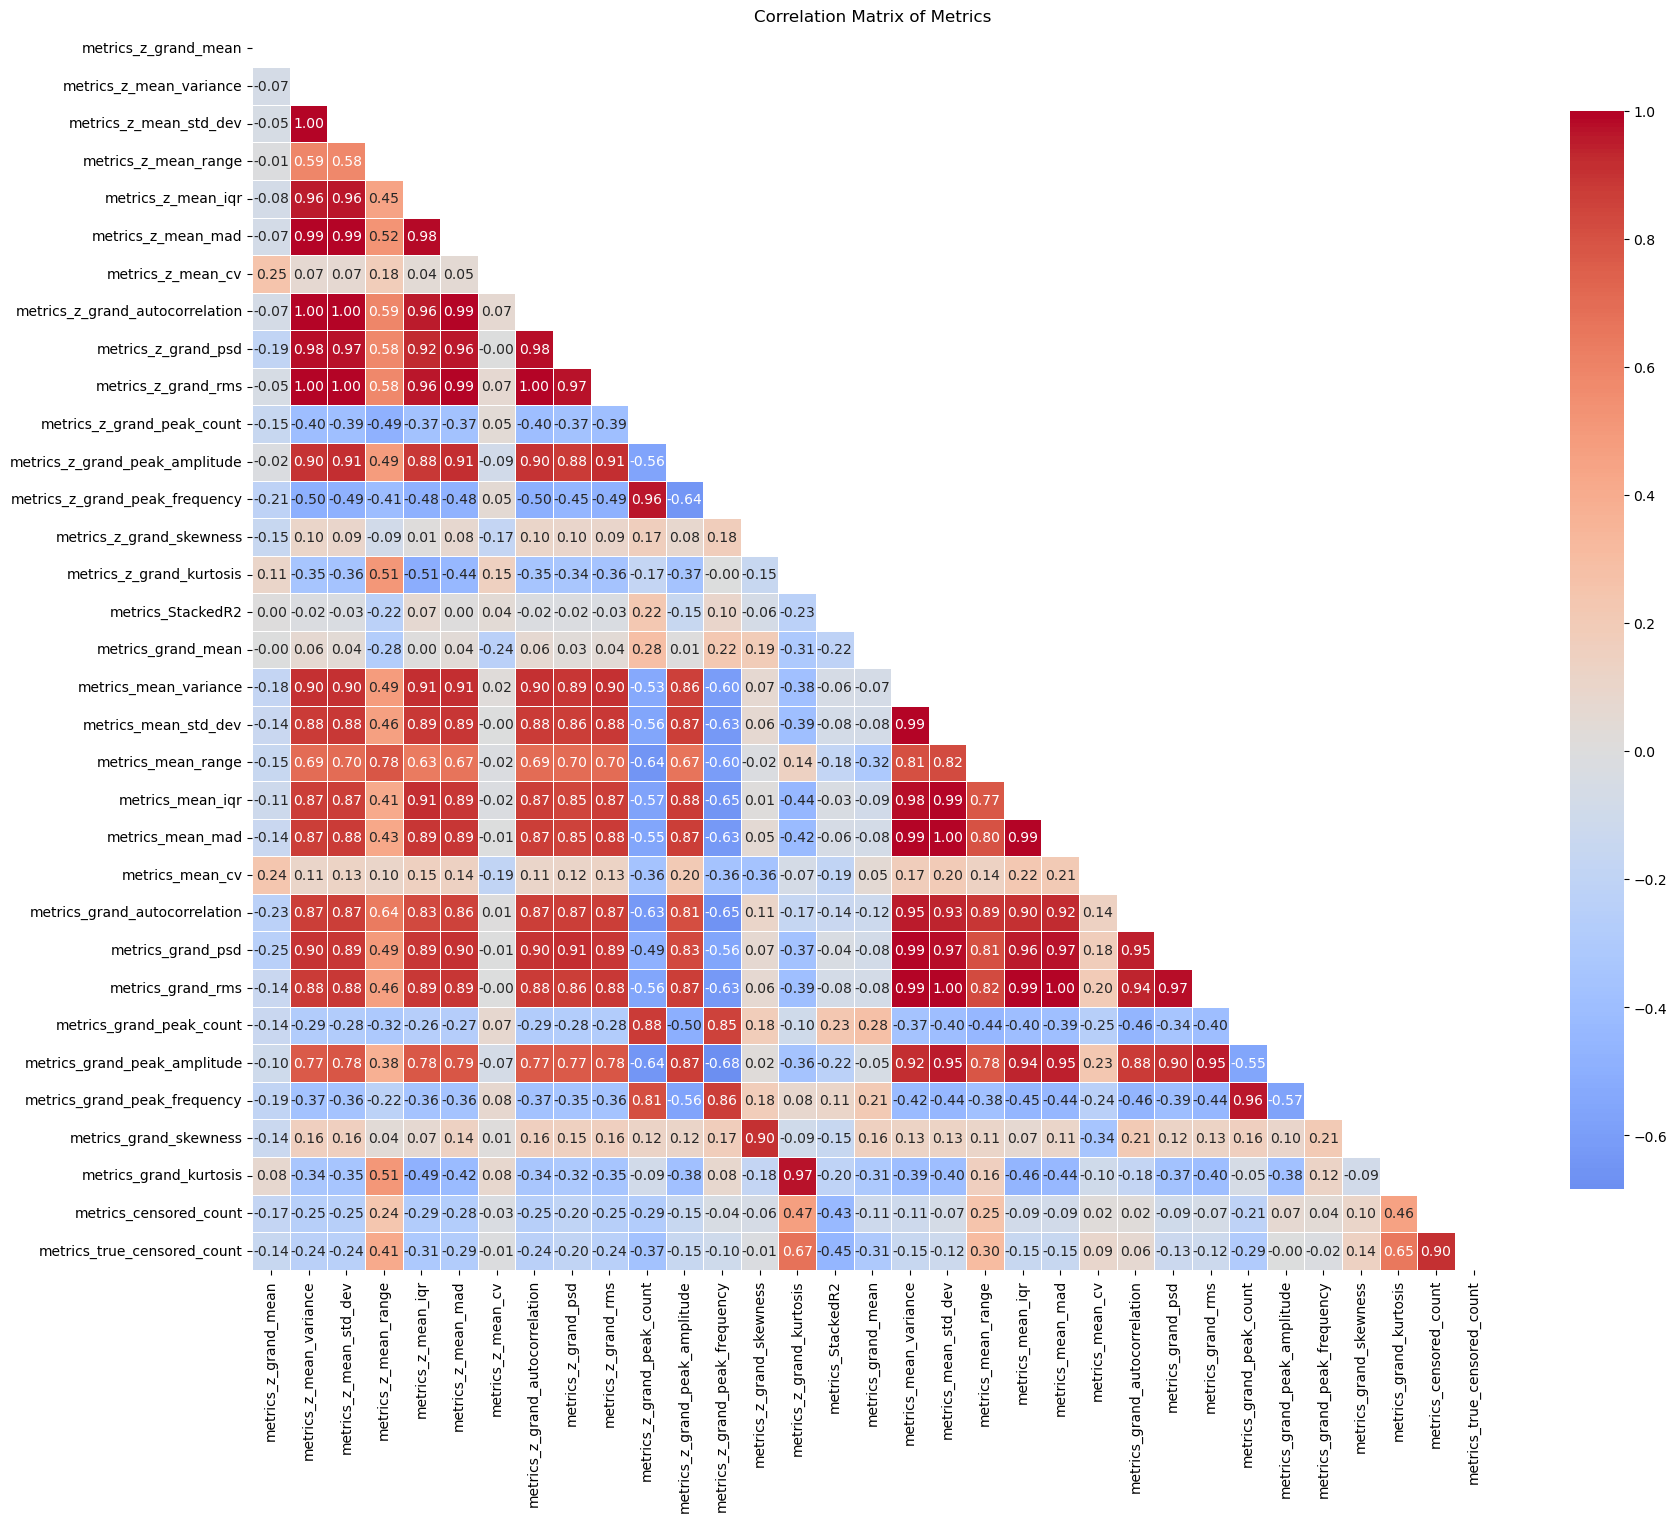

In [10]:
import pandas as pd
import seaborn as sns

# Convert dictionaries to DataFrames
df_metrics = pd.DataFrame(metrics)
df_metrics_z = pd.DataFrame(metrics_z)

# Combine DataFrames
df_combined = pd.concat([df_metrics_z, df_metrics], axis=1, keys=['metrics_z', 'metrics'])
#df_combined = pd.concat([metrics, metrics_z], axis=1, keys=['metrics_z', 'metrics'])

# Flatten MultiIndex columns
df_combined.columns = ['_'.join(col) for col in df_combined.columns]

# Compute correlation matrix
corr_matrix = df_combined.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Metrics')
# plt.show()




mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Choose a custom colormap (e.g., 'coolwarm')
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, center=0,
            square=True, fmt='.2f',linewidths=.5, cbar_kws={"shrink": 0.7})


# plt.xticks( np.arange(len(feature_names))+.5, feature_names, rotation=45)
# plt.yticks( np.arange(len(feature_names))+.5, feature_names, rotation=0)
plt.title("Correlation Matrix of Metrics")

plt.show()

### is "arousal" correlated with FD?

In [11]:
# import pandas as pd
# FD=[]
# for i, subject in enumerate(good_subjects_list):
#     confounds_file=f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/fmriprep_23.2.0/sub-{subject}/ses-HBNsiteRU/func/sub-{subject}_ses-HBNsiteRU_task-movieDM_desc-confounds_timeseries.tsv'
#     df = pd.read_csv(confounds_file, sep='\t')
#     FD.append(df['framewise_displacement'])
#     # max_fd.append(np.max(df['framewise_displacement']))
#     # mean_rmsd.append(np.mean(df['rmsd']))

mean_fd=[]
max_fd=[]
mean_rmsd=[]
for i, subject in enumerate(good_subjects_list):
    confounds_file=f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/fmriprep_23.2.0/sub-{subject}/ses-HBNsiteRU/func/sub-{subject}_ses-HBNsiteRU_task-movieDM_desc-confounds_timeseries.tsv'
    df = pd.read_csv(confounds_file, sep='\t')
    mean_fd.append(np.mean(df['framewise_displacement']))
    max_fd.append(np.max(df['framewise_displacement']))
    mean_rmsd.append(np.mean(df['rmsd']))

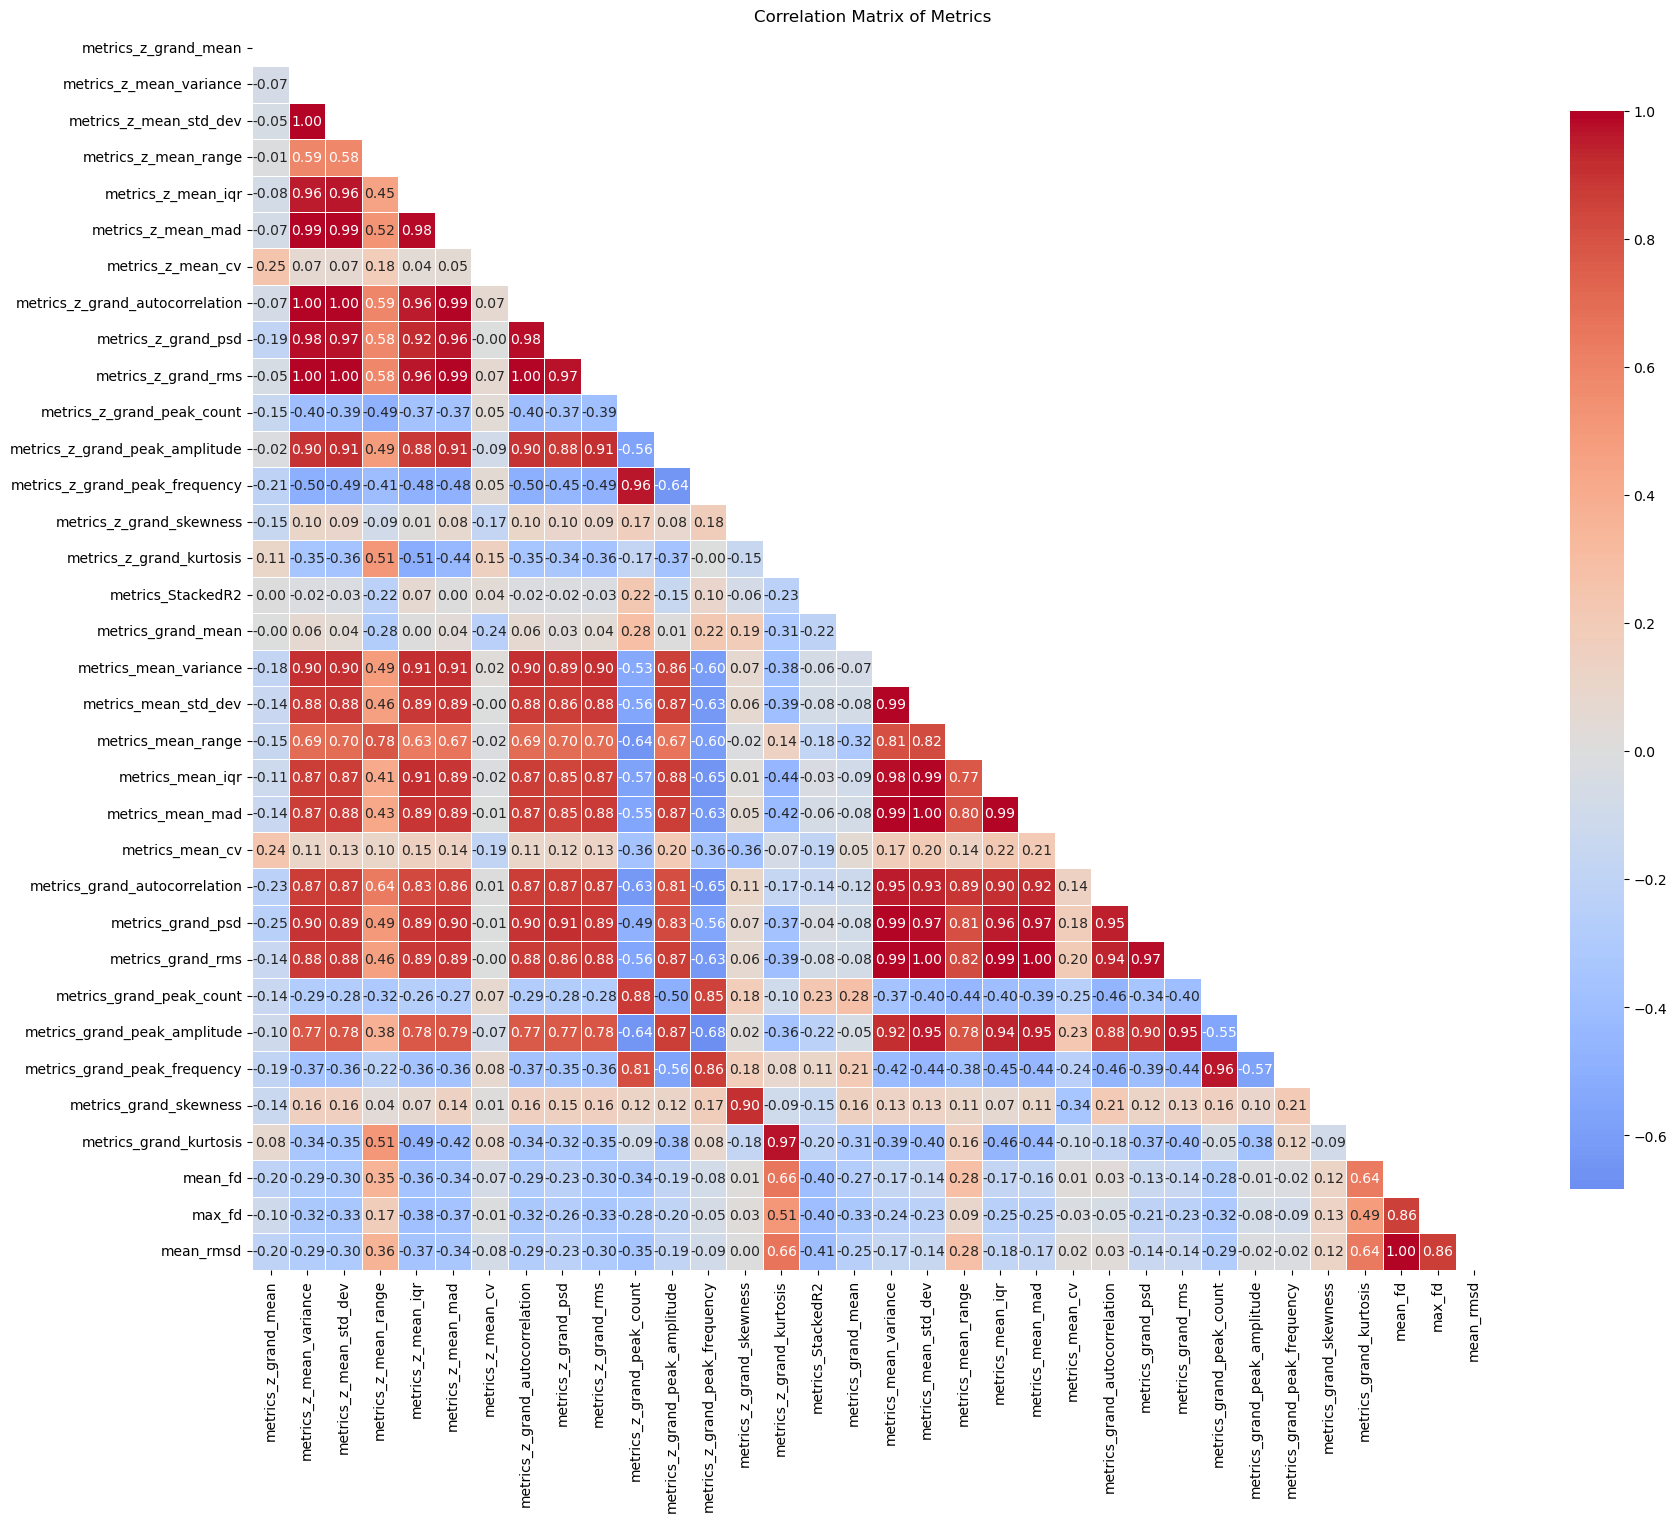

In [12]:
df_combined['mean_fd'] = mean_fd
df_combined['max_fd'] = max_fd
df_combined['mean_rmsd'] = mean_rmsd

corr_matrix = df_combined.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Metrics')
# plt.show()




mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Choose a custom colormap (e.g., 'coolwarm')
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, center=0,
            square=True, fmt='.2f',linewidths=.5, cbar_kws={"shrink": 0.7})


# plt.xticks( np.arange(len(feature_names))+.5, feature_names, rotation=45)
# plt.yticks( np.arange(len(feature_names))+.5, feature_names, rotation=0)
plt.title("Correlation Matrix of Metrics")

plt.show()

In [13]:
df_combined

,metrics_z_grand_mean,metrics_z_mean_variance,metrics_z_mean_std_dev,metrics_z_mean_range,metrics_z_mean_iqr,metrics_z_mean_mad,metrics_z_mean_cv,metrics_z_grand_autocorrelation,metrics_z_grand_psd,metrics_z_grand_rms,...,metrics_grand_psd,metrics_grand_rms,metrics_grand_peak_count,metrics_grand_peak_amplitude,metrics_grand_peak_frequency,metrics_grand_skewness,metrics_grand_kurtosis,mean_fd,max_fd,mean_rmsd
0,-1.480297e-18,0.189730,0.435580,2.356847,0.594760,0.352697,-2.942514e+17,0.094865,0.379151,0.435580,...,2.074347,1.050610,50.0,0.982244,0.066667,-0.062699,-0.340110,0.163850,3.372306,0.094214
1,0.000000e+00,0.188981,0.434720,2.287002,0.593920,0.347814,inf,0.094491,0.418205,0.434720,...,2.554509,1.069442,41.0,0.985441,0.055405,-0.337294,-0.367716,0.313734,6.833878,0.173322
2,-1.184238e-18,0.146904,0.383281,2.440150,0.484291,0.304244,-3.236518e+17,0.073452,0.307521,0.383281,...,1.087104,0.710291,52.0,0.586354,0.069333,-0.056371,0.243410,0.182758,1.458308,0.102586
3,-5.921189e-19,0.196773,0.443590,2.456097,0.613976,0.355939,-7.491577e+17,0.098386,0.428232,0.443590,...,1.429697,0.805639,50.0,0.652294,0.066667,-0.271872,0.261820,0.124445,1.085457,0.073136
4,-2.381175e-18,0.130588,0.361370,1.971821,0.473985,0.288783,-1.517612e+17,0.065294,0.273224,0.361370,...,0.909852,0.666071,50.0,0.612801,0.067024,0.034412,-0.158092,0.233047,6.392130,0.129159
5,-2.368476e-18,0.380752,0.617051,3.199201,0.794994,0.487610,-2.605267e+17,0.190376,0.842450,0.617051,...,4.545293,1.424762,42.0,1.228684,0.056000,0.137885,-0.216027,0.157112,2.183900,0.101676
6,0.000000e+00,0.164732,0.405872,2.278574,0.467753,0.310588,inf,0.082366,0.354379,0.405872,...,1.054010,0.704541,55.0,0.570054,0.073333,0.327245,0.383272,0.101185,0.517257,0.059158
7,-2.368476e-18,0.319619,0.565349,2.834960,0.825535,0.465921,-2.386972e+17,0.159809,0.712325,0.565349,...,3.822567,1.326074,47.0,1.086483,0.062667,-0.189180,-0.631708,0.119268,1.504648,0.066205
8,-5.976975e-19,0.139973,0.374130,2.084082,0.520107,0.300934,-6.259524e+17,0.069987,0.278983,0.374130,...,1.340936,0.832077,51.0,0.729255,0.068641,0.091055,0.101614,0.286297,5.791964,0.164202
9,-8.881784e-19,0.148046,0.384767,2.321155,0.499973,0.303589,-4.332093e+17,0.074023,0.284699,0.384767,...,1.401078,0.847808,50.0,0.680206,0.066667,0.040080,-0.306603,0.170866,1.228527,0.098983


In [14]:
#sns.pairplot(df_combined)

### what about adding the arousal measures

In [25]:
arousal_full_list=[]
for sub in good_subjects_list:
    arousal_full_multiplied=np.load(f'../data/features/{sub}_full_template_arousal.npy' )
    arousal_full_list.append(zscore(arousal_full_multiplied))
one_percent_list=[]
for sub in good_subjects_list:
    one_percent_multiplied=np.load(f'../data/features/{sub}_one_percent_arousal.npy' )
    one_percent_list.append(zscore(one_percent_multiplied))


In [33]:
arousal_full_drop=[]
for i,sub in enumerate(good_subjects_list):
    arousal_full_drop.append(arousal_full_list[i][0]-arousal_full_list[i][-1])
print(arousal_full_drop)

mean10_arousal_full_drop=[]
for i,sub in enumerate(good_subjects_list):
    mean10=np.mean(arousal_full_list[i][0:10])-np.mean(arousal_full_list[i][-10:])
    mean10_arousal_full_drop.append(mean10)
print(mean10_arousal_full_drop)

mean50_arousal_full_drop=[]
for i,sub in enumerate(good_subjects_list):
    mean50=np.mean(arousal_full_list[i][0:50])-np.mean(arousal_full_list[i][-50:])
    mean50_arousal_full_drop.append(mean50)
print(mean50_arousal_full_drop)

mean100_arousal_full_drop=[]
for i,sub in enumerate(good_subjects_list):
    mean100=np.mean(arousal_full_list[i][0:100])-np.mean(arousal_full_list[i][-100:])
    mean100_arousal_full_drop.append(mean100)
print(mean100_arousal_full_drop)



one_percent_drop=[]
for i,sub in enumerate(good_subjects_list):
    one_percent_drop.append(one_percent_list[i][0]-one_percent_list[i][-1])
print(one_percent_drop)

mean10_one_percent_drop=[]
for i,sub in enumerate(good_subjects_list):
    mean10=np.mean(one_percent_list[i][0:10])-np.mean(one_percent_list[i][-10:])
    mean10_one_percent_drop.append(mean10)
print(mean10_one_percent_drop)

mean50_one_percent_drop=[]
for i,sub in enumerate(good_subjects_list):
    mean10=np.mean(one_percent_list[i][0:50])-np.mean(one_percent_list[i][-50:])
    mean50_one_percent_drop.append(mean10)
print(mean50_one_percent_drop)


mean100_one_percent_drop=[]
for i,sub in enumerate(good_subjects_list):
    mean10=np.mean(one_percent_list[i][0:100])-np.mean(one_percent_list[i][-100:])
    mean100_one_percent_drop.append(mean10)
print(mean100_one_percent_drop)


[0.8153314569601138, -0.06854273901280639, -0.06448603368803386, 1.0402026414612897, 3.788331491969944, -5.1695813288353385, -2.9848903080808746, -2.8547475830770797, -0.9121506511558242, 1.9300352332974344, 0.006508812499053995, -1.2788157270239489, -1.942947575320526, -2.9245330513723715, -4.210566643485802, -3.0860182168037182, 1.3360931482348501, -0.988555653916824, -4.447250534103154, 0.9623620768311869, 0.5100200265036967, 3.2357455157942554, -0.9460549043212979, -1.9893873206713422, 0.944290723032025]
[2.7537961542363636, 1.5750397042895143, 2.1145758161728425, 3.310580470215694, 3.710882495638612, -4.389128752947312, -2.0669117342232934, -1.4797774443964795, 1.0025527079699472, 3.122782745256206, 2.5488723361159007, 1.5720292971575403, 1.2945421142236555, -2.309228101344802, -1.480248753231192, -2.4246188551676653, 2.212576710606211, 1.3036424362520063, -0.7745025751440845, 2.2395281022413553, 2.2647323388297775, 3.1832304199744916, 2.6910545239072254, 0.6671000773704828, 1.823

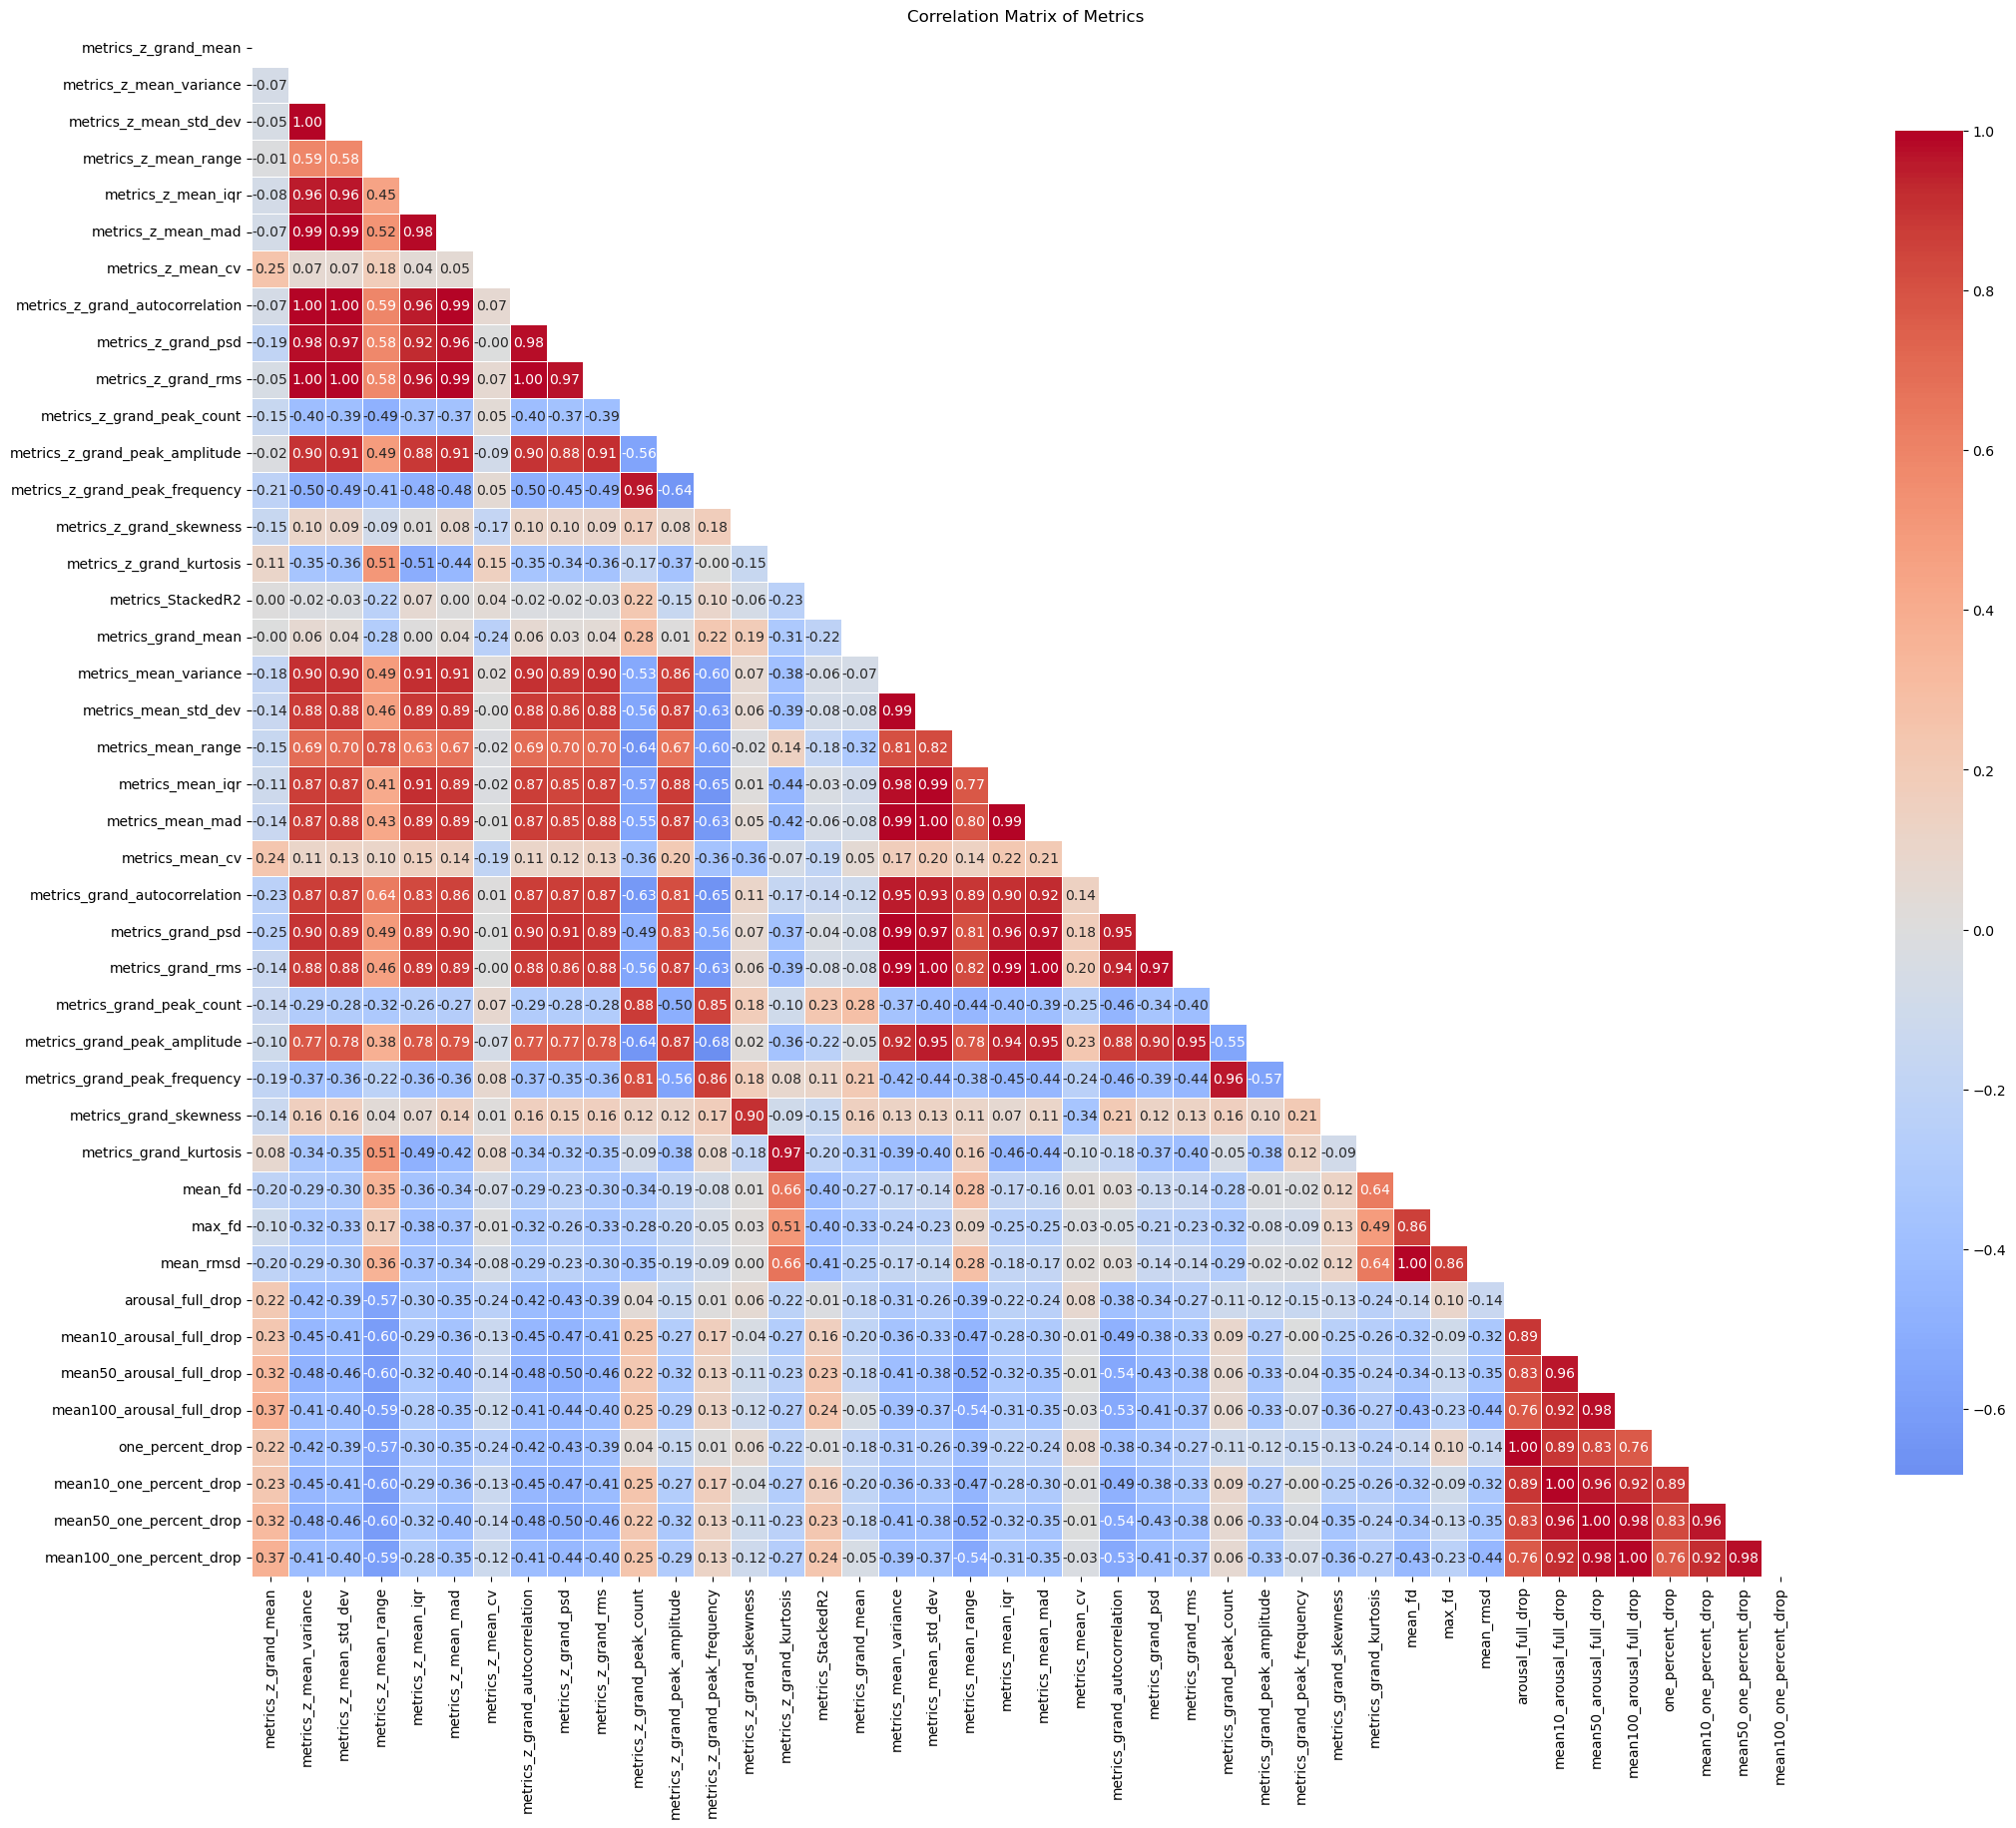

In [36]:
df_combined['arousal_full_drop'] = arousal_full_drop
df_combined['mean10_arousal_full_drop'] = mean10_arousal_full_drop
df_combined['mean50_arousal_full_drop'] = mean50_arousal_full_drop
df_combined['mean100_arousal_full_drop'] = mean100_arousal_full_drop

df_combined['one_percent_drop'] = arousal_full_drop
df_combined['mean10_one_percent_drop'] = mean10_arousal_full_drop
df_combined['mean50_one_percent_drop'] = mean50_arousal_full_drop
df_combined['mean100_one_percent_drop'] = mean100_arousal_full_drop

corr_matrix = df_combined.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Metrics')
# plt.show()




mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Choose a custom colormap (e.g., 'coolwarm')
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, center=0,
            square=True, fmt='.2f',linewidths=.5, cbar_kws={"shrink": 0.7})


# plt.xticks( np.arange(len(feature_names))+.5, feature_names, rotation=45)
# plt.yticks( np.arange(len(feature_names))+.5, feature_names, rotation=0)
plt.title("Correlation Matrix of Metrics")

plt.show()

### testing adding the v1 features to models

In [4]:
sub=good_subjects_list[0]

In [10]:
v1_feat=np.load(f'../data/features/{sub}_DM_v1.npy')
v1_feat.shape

# arousal_feat=np.load(f'../data/features/{sub}_one_percent_arousal.npy')
# arousal_feat.shape

(750, 1711)

In [6]:
import pilot
X,features=pilot.load_features('concatspeech') #load X
v1_feat=np.load(f'../data/features/{sub}_DM_v1.npy')

In [7]:
X.shape[0]
v1_feat=np.load(f'../data/features/{sub}_DM_v1.npy')
X = np.column_stack((X, v1_feat[:X.shape[0]]))
X_new.shape

NameError: name 'X_new' is not defined

In [70]:
sub='NDARHJ830RXD'
%run pilot.py -s $sub -p a4a5 -f concatspeech -d 0 -r -v

running subject NDARHJ830RXD
loaded brain data
run ridgecv
No value was passed to args.bootstrap
MEAN test R^2 Score:  0.00
16.7694411277771
saving results
MEAN train R^2 Score:  0.03


In [ ]:
for sub in good_subjects_list:
    print(f'SUB-{sub} NO V1******************')
    %run pilot.py -s $sub -p a4a5 -f concatspeech -d 0 -r
    print(f'SUB-{sub} WITH V1****************++++++')
    %run pilot.py -s $sub -p a4a5 -f concatspeech -d 0 -r -v
    print(f'****************++++++****************++++++****************++++++*************')

#python pilot.py -s $sub -p a4a5 -f concatspeech -d 0 -r


In [86]:
r2=[]
r2_v1=[]
r2_train=[]
r2_v1_train=[]
for sub in good_subjects_list:
    loaded=np.load(f'../good_pilots/sub-{sub}_roi-a4a5_feat-concatspeech_delay-0_ridgecv.npz')
    r2.append(np.mean(loaded['stacked_r2s']))
    r2_train.append(np.mean(loaded['train_r2_list']))
    loaded=np.load(f'../good_pilots/sub-{sub}_roi-a4a5_feat-concatspeech_delay-0_v1_ridgecv.npz')
    r2_v1.append(np.mean(loaded['stacked_r2s']))
    r2_v1_train.append(np.mean(loaded['train_r2_list']))

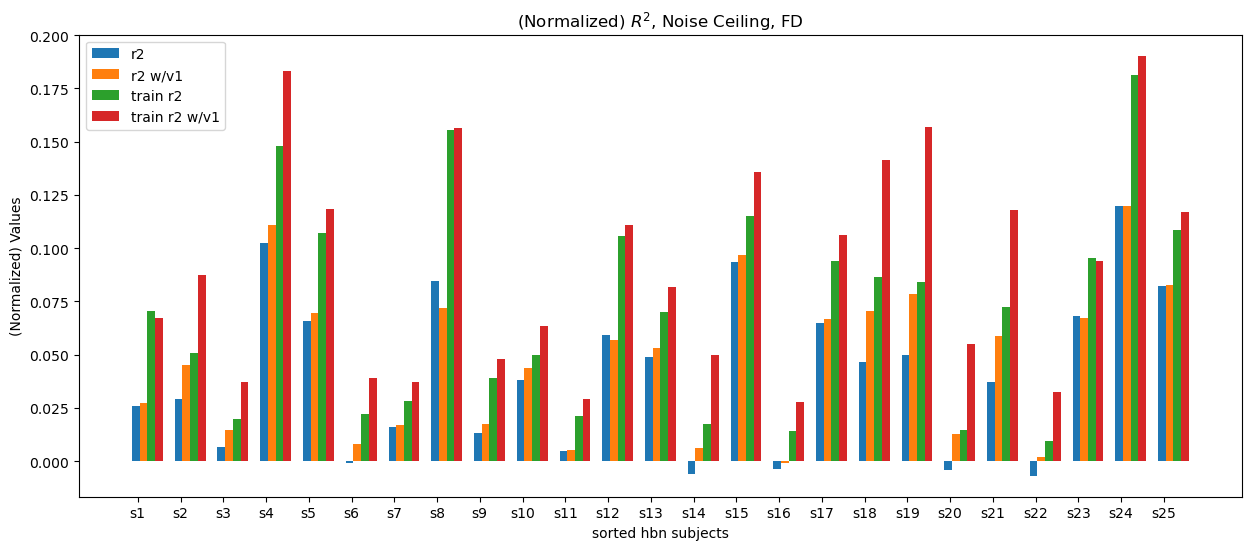

In [87]:
# Number of groups
N = len(r2)

# List of all lists
#data = [[f/max(r2_list_sorted) for f in r2_list_sorted], [f/max(noise_ceiling_sorted) for f in noise_ceiling_sorted], [f/max(mriqc_fd_mean_list_sorted) for f in mriqc_fd_mean_list_sorted], [f/max(mean_fd_sorted) for f in mean_fd_sorted]]
data=[r2,r2_v1,r2_train,r2_v1_train]


# Number of bars in each group
num_bars = len(data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Set the positions of the groups and width of the bars
ind = np.arange(N)
width = 0.18
#labels=['$R^2$',f'Subject Specific Mean Noise Ceiling (r={noise_ceiling_r:.02f})',f'MRIQC mean FD (r={mriqc_fd_mean_list_r:.02f})', f'fMRIPrep Mean FD (r={mean_fd_r:.02f})']
labels=['r2','r2 w/v1','train r2','train r2 w/v1']
# Create bars for each list
for i, lst in enumerate(data):
    ax.bar(ind + i*width, lst, width, label=f'{labels[i]}')

# Add labels, title, and legend
ax.set_xlabel('sorted hbn subjects')
ax.set_ylabel('(Normalized) Values')
ax.set_title('(Normalized) $R^2$, Noise Ceiling, FD ')
ax.set_xticks(ind + width / num_bars)
ax.set_xticklabels([f's{i+1}' for i in range(N)])
ax.legend()

# Show the plot
plt.show()

/tmp/ipykernel_1467607/1010441582.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['$R^2$','$R^2$ w/v1','train $R^2$','train $R^2$ w/v1'])


[Text(0, 0, '$R^2$'),
 Text(1, 0, '$R^2$ w/v1'),
 Text(2, 0, 'train $R^2$'),
 Text(3, 0, 'train $R^2$ w/v1')]

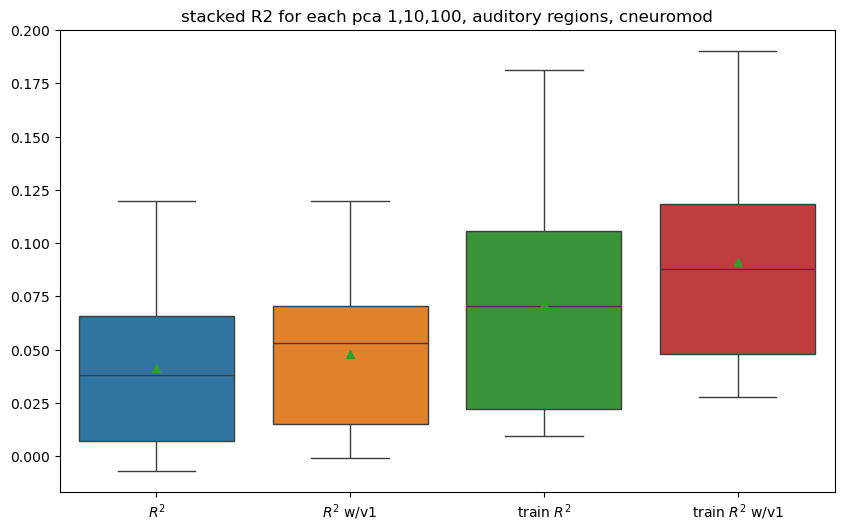

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data,showmeans=True)
plt.title(f'$R^2$ with and without V1 timecourse for HBN')
ax.set_xticklabels(['$R^2$','$R^2$ w/v1','train $R^2$','train $R^2$ w/v1'])

In [39]:
test_img=hcp_utils.cortex_data(img_y[0])
test_img=test_img*(label_data-1)


In [ ]:
plotting.view_surf(hcp_utils.mesh.inflated, surf_map=test_img)

In [ ]:
metrics = {
    'grand_mean': [],
}


for v in v1_list:
    v_mean=np.mean(v,axis=1)
    metrics['grand_mean'].append(np.mean(v_mean))

## now do the same but add the arousal templates to the features

In [ ]:
for sub in good_subjects_list:
    # print(f'SUB-{sub} NO V1******************')
    # %run pilot.py -s $sub -p a4a5 -f concatspeech -d 0 -r
    # print(f'SUB-{sub} WITH V1****************++++++')
    %run pilot.py -s $sub -p a4a5 -f concatspeech -d 0 -r -o
    print(f'****************++++++****************++++++****************++++++*************')

#python pilot.py -s $sub -p a4a5 -f concatspeech -d 0 -r


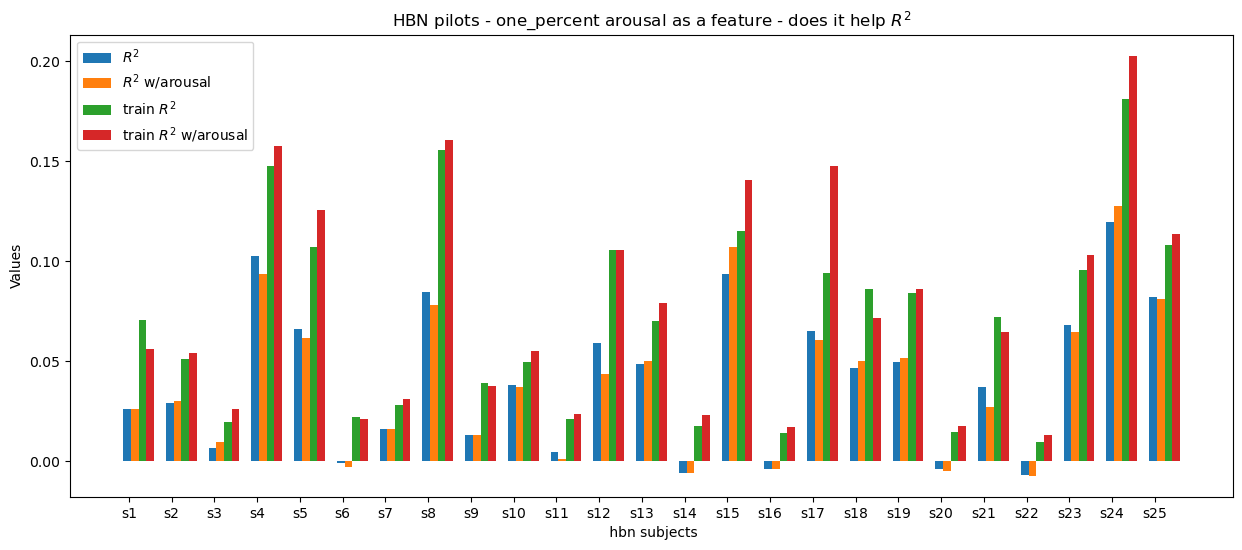

/tmp/ipykernel_2431964/4148195862.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['$R^2$','$R^2$ w/arousal','train $R^2$','train $R^2$ w/arousal'])


[Text(0, 0, '$R^2$'),
 Text(1, 0, '$R^2$ w/arousal'),
 Text(2, 0, 'train $R^2$'),
 Text(3, 0, 'train $R^2$ w/arousal')]

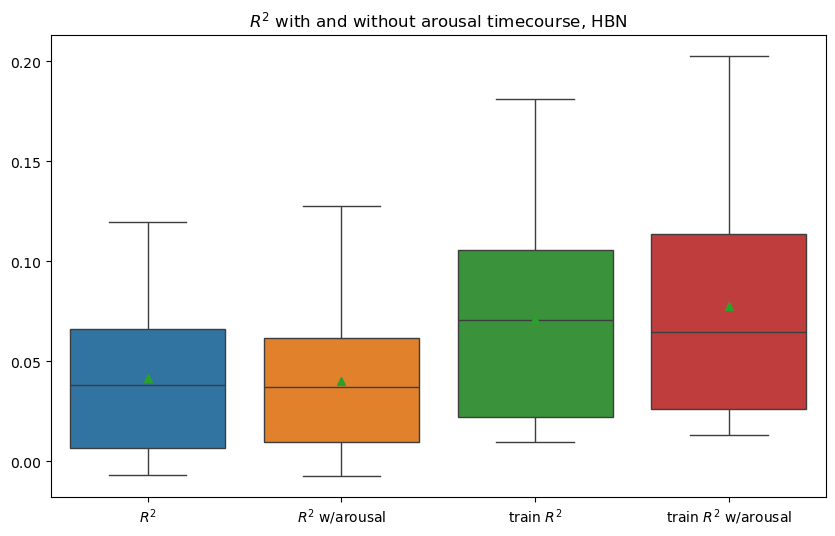

In [17]:
r2=[]
r2_v1=[]
r2_train=[]
r2_v1_train=[]
for sub in good_subjects_list:
    loaded=np.load(f'../good_pilots/sub-{sub}_roi-a4a5_feat-concatspeech_delay-0_ridgecv.npz')
    r2.append(np.mean(loaded['stacked_r2s']))
    r2_train.append(np.mean(loaded['train_r2_list']))
    loaded=np.load(f'../good_pilots/sub-{sub}_roi-a4a5_feat-concatspeech_delay-0_arousal_ridgecv.npz')
    r2_v1.append(np.mean(loaded['stacked_r2s']))
    r2_v1_train.append(np.mean(loaded['train_r2_list']))




# Number of groups
N = len(r2)

# List of all lists
#data = [[f/max(r2_list_sorted) for f in r2_list_sorted], [f/max(noise_ceiling_sorted) for f in noise_ceiling_sorted], [f/max(mriqc_fd_mean_list_sorted) for f in mriqc_fd_mean_list_sorted], [f/max(mean_fd_sorted) for f in mean_fd_sorted]]
data=[r2,r2_v1,r2_train,r2_v1_train]


# Number of bars in each group
num_bars = len(data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Set the positions of the groups and width of the bars
ind = np.arange(N)
width = 0.18
#labels=['$R^2$',f'Subject Specific Mean Noise Ceiling (r={noise_ceiling_r:.02f})',f'MRIQC mean FD (r={mriqc_fd_mean_list_r:.02f})', f'fMRIPrep Mean FD (r={mean_fd_r:.02f})']
labels=['$R^2$','$R^2$ w/arousal','train $R^2$','train $R^2$ w/arousal']
# Create bars for each list
for i, lst in enumerate(data):
    ax.bar(ind + i*width, lst, width, label=f'{labels[i]}')

# Add labels, title, and legend
ax.set_xlabel(' hbn subjects')
ax.set_ylabel('Values')
ax.set_title('HBN pilots - one_percent arousal as a feature - does it help $R^2$')
ax.set_xticks(ind + width / num_bars)
ax.set_xticklabels([f's{i+1}' for i in range(N)])
ax.legend()

# Show the plot
plt.show()





fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data,showmeans=True)
plt.title(f'$R^2$ with and without arousal timecourse, HBN')
ax.set_xticklabels(['$R^2$','$R^2$ w/arousal','train $R^2$','train $R^2$ w/arousal'])